# Neural posterior estimation

This tutorial demonstrates how to perform neural posterior estimation (NPE) with `lampe`.

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from itertools import islice
from tqdm import tqdm

from lampe.data import JointLoader
from lampe.distributions import BoxUniform
from lampe.inference import NPE
from lampe.plots import nice_rc, corner
from lampe.simulators.slcp import SLCP, LOWER, UPPER, LABELS
from lampe.utils import GDStep

## Simulator

In `lampe`, a simulator can be any Python callable that takes a set of parameters $\theta$ as input and returns a stochastic observation $x$ as output. The simulator we use for this tutorial is SLCP, a toy simulator which has a simple likelihood $p(x | \theta)$ but a complex (multimodal) posterior $p(\theta | x)$. Its five parameters are dimensionless and observations lie in $\mathbb{R}^8$.

To define a joint distribution $p(\theta, x)$, we couple our simulator with a prior $p(\theta)$, which we choose uniform over the hypercube $[-3, 3]^5$. The `lampe.priors` module provides helpers to build priors as [PyTorch distributions](https://pytorch.org/docs/stable/distributions.html). Notably, the `BoxUniform` class creates a multivariate uniform distribution.

In [2]:
prior = BoxUniform(LOWER, UPPER)
sim = SLCP()

theta = prior.sample()
x = sim(theta)

theta, x

(tensor([ 0.9009,  1.9061, -2.1973, -2.2692,  1.8743]),
 tensor([1.7642, 2.1906, 3.3633, 5.6625, 3.5570, 4.5507, 4.4325, 6.1453]))

To perform neural posterior estimation, we need to get pairs $(\theta, x) \sim p(\theta, x)$. If the simulator is fast and/or inexpensive, a solution is to generate pairs while training. The `lampe.data` module provides `JointLoader` to create an iterable [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) of batched pairs $(\theta, x) \sim p(\theta, x)$, given a prior $p(\theta)$ and a simulator.

The prior must be a `torch` distribution and the simulator must take and return NumPy arrays or PyTorch tensors. In our case, the simulator is compatible with PyTorch and also supports "batching", that is a batch of simulations can be carried through at once.

In [3]:
loader = JointLoader(prior, sim, batch_size=2**10, numpy=False, batched=True)

## Training

Similar to PyTorch, `lampe` provides building blocks, such as network architecture and loss functions, that should be put together by the user to perform inference. In the case of neural posterior estimation (NPE), we have to train a conditional normalizing flow $p_\phi(\theta | x)$ at approximating the posterior distribution $p(\theta | x)$.

First, we use the `NPE` class provided by `lampe.nn` to create a normalizing flow adapted to the simulator's input and output sizes.

In [4]:
estimator = NPE(5, 8, transforms=3, hidden_features=[128] * 3)
estimator.cuda()

NPE(
  (flow): MAF(
    (transforms): ModuleList(
      (0): MaskedAutoregressiveTransform(
        (base): MonotonicAffineTransform()
        (order): [0, 1, 2, 3, 4]
        (params): MaskedMLP(
          (0): MaskedLinear(in_features=13, out_features=128, bias=True)
          (1): ReLU()
          (2): MaskedLinear(in_features=128, out_features=128, bias=True)
          (3): ReLU()
          (4): MaskedLinear(in_features=128, out_features=128, bias=True)
          (5): ReLU()
          (6): MaskedLinear(in_features=128, out_features=10, bias=True)
        )
      )
      (1): MaskedAutoregressiveTransform(
        (base): MonotonicAffineTransform()
        (order): [4, 3, 2, 1, 0]
        (params): MaskedMLP(
          (0): MaskedLinear(in_features=13, out_features=128, bias=True)
          (1): ReLU()
          (2): MaskedLinear(in_features=128, out_features=128, bias=True)
          (3): ReLU()
          (4): MaskedLinear(in_features=128, out_features=128, bias=True)
          (5)

Then, we define the loss function to minimize. In our case, the loss is simply the negative log-likelihood $- \log p_\phi(\theta | x)$ of the data.

In [5]:
def loss(theta, x):
    log_p = estimator(theta, x)  # log p(theta | x)
    return -log_p.mean()

Finally, similar to most neural networks, we implement the training routine as a series of stochastic gradient descent (SGD) epochs over the training set. Because `lampe` is based on PyTorch, any `torch` optimizer can be used (e.g. [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD), [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam), ...) and features such as gradient clipping can be easily implemented.

In [6]:
optimizer = optim.AdamW(estimator.parameters(), lr=1e-3, weight_decay=1e-3)
step = GDStep(optimizer, clip=1.)  # gradient descent step with gradient clipping

estimator.train()

with tqdm(range(64), unit='epoch') as tq:
    for epoch in tq:
        losses = torch.stack([
            step(loss(theta.cuda(), x.cuda()))
            for theta, x in islice(loader, 2**10)  # 1024 batches per epoch
        ])

        tq.set_postfix(loss=losses.mean().item())

100%|██████████| 64/64 [26:24<00:00, 24.77s/epoch, loss=2.64]


## Inference

Now that the posterior estimator is trained, we can use it to perform inference. For instance, we can inspect the posterior of an observation $x^*$. Since normalizing flows are proper distributions, we can sample directly from $p_\phi(\theta | x^*)$ and visualize the distribution with the `corner` function provided by `lampe.plots`. 

In [7]:
theta_star = torch.tensor([0.3517, -0.0883, -1.4778, 1.6406, -1.9085])
x_star = sim(theta_star).cuda()

estimator.eval()

samples = estimator.sample(x_star, (2**20,)).cpu()

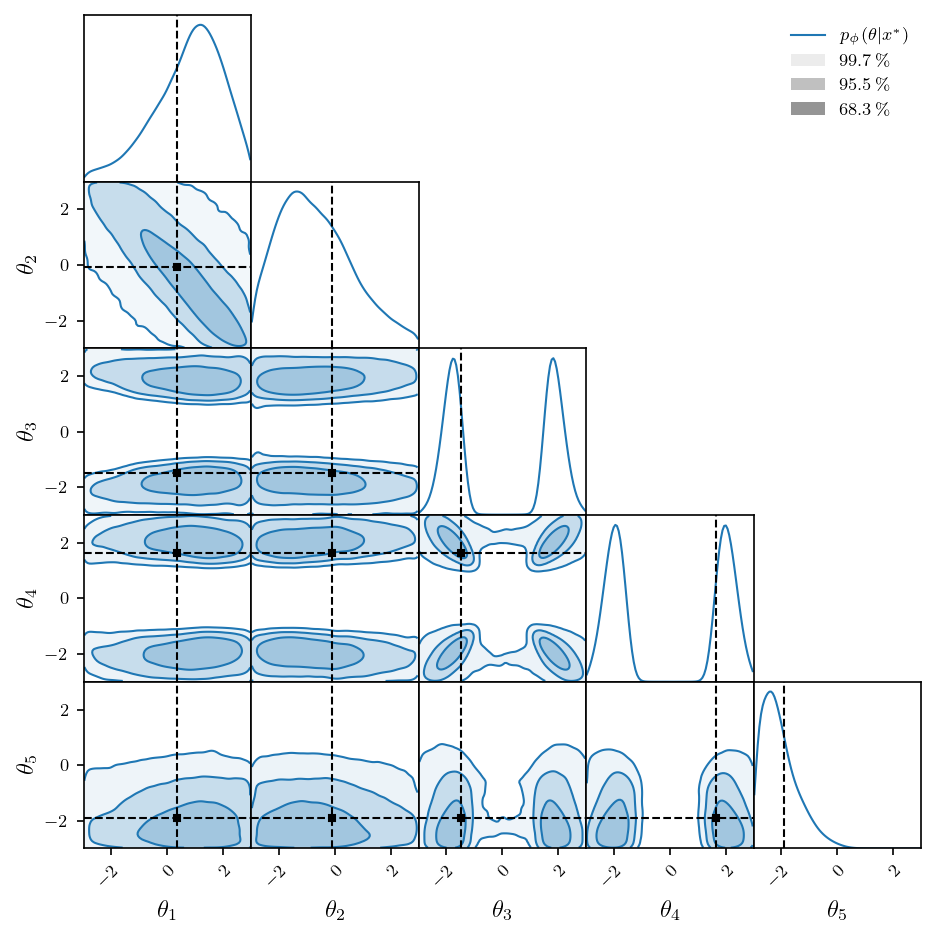

In [8]:
plt.rcParams.update(nice_rc(latex=True))  # nicer plot settings

fig = corner(
    samples,
    smooth=2.,
    bounds=(LOWER, UPPER),
    labels=LABELS,
    legend=r'$p_\phi(\theta | x^*)$',
    markers=[theta_star],
)